<a href="https://colab.research.google.com/github/fazekas-gergo/composer-ai/blob/master/ComposerAI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Composer AI
Authors: Fazekas Gergő and Joseph Tadrous<br>
Used dataset: https://www.kaggle.com/soumikrakshit/classical-music-midi




---
# 0. Setup environment
At first clone the repository, which contains the raw dataset and the created dataframe (which was created in the *Create_DataFrame.ipynb* file).<br>
Then install the required packages and other necessary tools. 

In [ ]:
%cd /content/
!rm -rf composer-ai
!git clone -l -s https://github.com/fazekas-gergo/composer-ai composer-ai
!pip install midi2audio
!pip install pretty_midi
!sudo apt-get install fluidsynth

In [2]:
%cd composer-ai

/content/composer-ai


Import required python packages.

In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import preprocessing

import music21
import pretty_midi
from pretty_midi import Note
from midi2audio import FluidSynth
from IPython.display import Audio
from datetime import datetime

from tensorflow import keras
from tensorflow.keras.layers import LSTM, Dense, Dropout, Conv1D, Flatten, Input, concatenate
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.losses import MeanSquaredError, BinaryCrossentropy
from keras.utils.vis_utils import plot_model

---
# 1. Implement tools
We implement our tools here in the interest of cleaner and more transparent code.

## Handling pitches
We had to define some methods and constant values, which makes us able to tokenize and detokenize the pitches.

In [4]:
min_pitch = 21
max_pitch = 108
pitch_scale_len = max_pitch - min_pitch

def tokenize(pitches):
    note = np.zeros(max_pitch-min_pitch, dtype=int)
    for pitch in pitches:
        note[pitch - min_pitch] = 1
    return note

def tokenize_all(pitches_list):
    return [tokenize(pitches) for pitches in pitches_list]

def detokenize(token):
    return np.argwhere(token == 1).reshape(-1) + min_pitch

def detokenize_all(tokens):
    return [detokenize(token) for token in tokens]

## Music Generator class
The music generator class is able to generate music using the fit model and the scaler.<br>
It also contains randomity (which can be set with the temperature parameter) to avoid stucking into a too simple pattern (like pressing one piano key endlessly).


In [20]:
class MusicGenerator:
    def __init__(self, model, scaler, min_pitch_num: int = 1, max_pitch_num: int = 10):
        self.model = model
        self.win = self.model.input_shape[0][1]
        self.scaler = scaler
        self.temperature = None
        self.min_pitch_num, self.max_pitch_num = min_pitch_num, max_pitch_num

    def generate(self, num, temperature: float = 1.0):
        self.temperature = temperature
        df = self.__create_df(size=num + self.win)
        self.__make_predictions(df, num)
        self.__transform(df)
        return df.iloc[self.win:].reset_index(drop=True)

    @staticmethod
    def __create_df(size):
        df = pd.DataFrame(np.random.random((size, 3)), index=np.arange(size), columns=['pitches', 'duration', 'velocity'])
        df.pitches = [np.random.randint(2, size=pitch_scale_len, dtype=int) for _ in range(size)]
        return df

    def __make_predictions(self, df, num):
        for i in range(num):
            df.iloc[i + self.win] = self.__predict(df.iloc[i:i + self.win])

    def __transform(self, df):
        df.pitches = detokenize_all(df.pitches)
        df[['duration', 'velocity']] = self.scaler.inverse_transform(df[['duration', 'velocity']])
        df.velocity = np.round(df.velocity).astype(int)

    def __predict(self, df):
        x_pitches = np.expand_dims(np.array([arr for arr in df['pitches']]), axis=0)
        x_dur_vel = np.expand_dims(df[['duration', 'velocity']].values, axis=0)
        pred_pitches, pred_dur_vel = self.model.predict([x_pitches, x_dur_vel])
        return self.__tokenize_pitches(pred_pitches[0]), pred_dur_vel[:, 0], pred_dur_vel[:, 1]

    def __tokenize_pitches(self, preds):
        pred_pitches = np.argwhere(preds >= 0.5).reshape(-1)
        if len(pred_pitches) < self.min_pitch_num and self.min_pitch_num > 1:
            pred_pitches = np.argsort(preds)[-self.min_pitch_num:]
        elif len(pred_pitches) == 0:
            pred_pitches = self.__random_sample(preds)
        elif len(pred_pitches) > self.max_pitch_num:
            pred_pitches =  np.argsort(preds)[-self.max_pitch_num:]
        pred_pitches += min_pitch
        return tokenize(pred_pitches)

    def __random_sample(self, preds):
        preds = np.asarray(preds).astype('float64')
        preds = np.log(preds) / self.temperature
        exp_preds = np.exp(preds)
        preds = exp_preds / np.sum(exp_preds)
        probs = np.random.multinomial(1, preds, 1)
        return np.atleast_2d(np.argmax(probs))

## Conversion between MIDI and listenable file
The MIDI files only contain information about the music, but does not define the exact sound of it, so we cannot listen it. <br>
Therefore we had to implement methods to create listenable files using piano sound. 

In [6]:
def convert_midi_to_flac(music_path, output='music'):
  FluidSynth('piano.sf2').midi_to_audio(music_path, 'music' + '.flac')
  return 'music' + '.flac'

def play_music(music_path):
  convert_midi_to_flac(music_path, output='music')
  return 'music.flac'

In [7]:
def create_midi_file_from_df(df, file_name='output.mid'):
  music = pretty_midi.PrettyMIDI()
  piano = pretty_midi.Instrument(program=pretty_midi.instrument_name_to_program('Acoustic Grand Piano'))

  start = 0
  for index, note in generated.iterrows():
    for pitch in note['pitches']:
      piano.notes.append(Note(pitch=pitch,
                              velocity=int(note['velocity']), 
                              start=start, 
                              end=start+note['duration']))
    start += note['duration']
  
  # Add the piano instrument to the PrettyMIDI object
  music.instruments.append(piano)
  # Write out the MIDI data
  music.write(file_name)

---
# 2. Data Exploration
Let's check some music piece from the dataset.

The *music21* package lets us to plot the midi file.

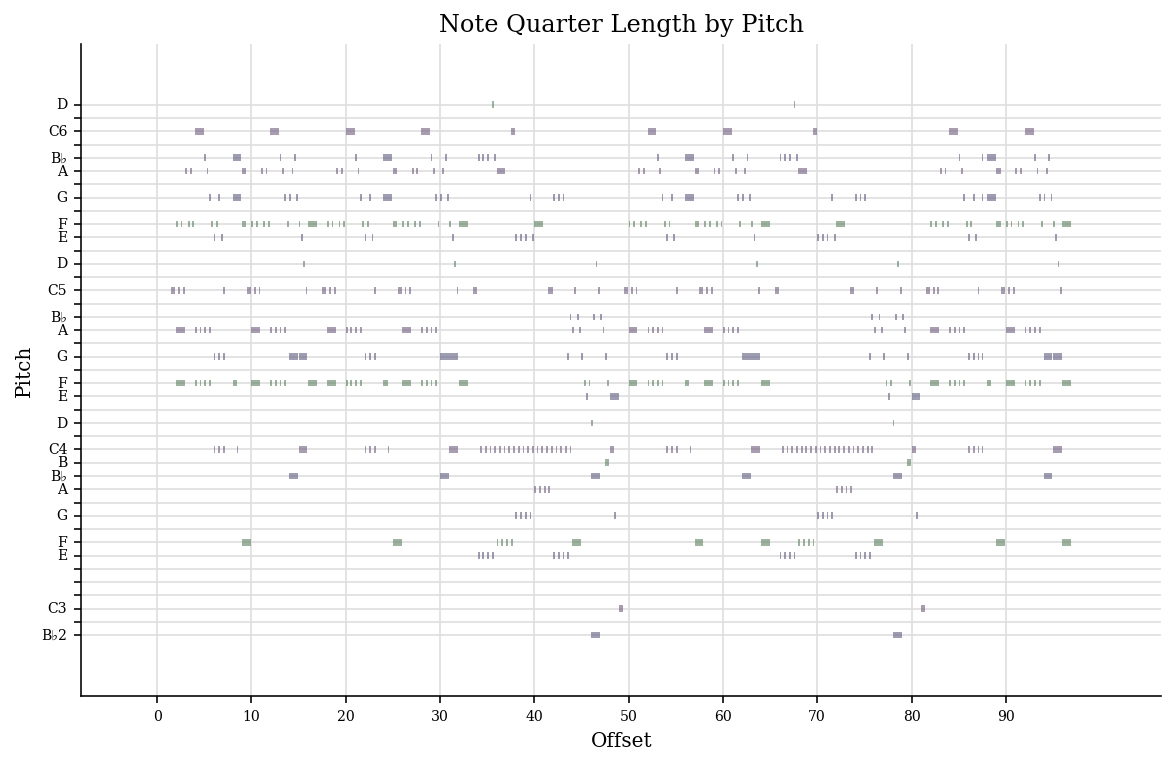

In [ ]:
music = music21.converter.parse('classical_music_midi/haydn/haydn_9_3.mid')
music.plot()

The convert_midi_to_flac function is able to convert the midi file to be listenable by using a soundfont file.

In [ ]:
Audio(play_music('classical_music_midi/haydn/haydn_9_3.mid'))

---
# 3. Load Data Frame

Load dataframe which was already created in the *Create_DataFrame.ipynb* file.<br>

In [8]:
dataset = pd.read_pickle('./dataset.pkl')
dataset.index.names = ['title', 'index']
dataset

pitches   velocity  \
title                index                                                
haydn/haydn_9_3.mid  0                                  [72]  40.000000   
                     1                          [65, 69, 77]  35.666667   
                     2                                  [72]  40.000000   
                     3                                  [77]  41.000000   
                     4                                  [72]  42.000000   
...                                                      ...        ...   
liszt/liz_rhap12.mid 3105   [44, 48, 51, 56, 75, 80, 84, 87]  77.375000   
                     3106   [37, 41, 44, 49, 77, 80, 85, 89]  77.375000   
                     3107   [32, 36, 39, 44, 80, 84, 87, 92]  77.375000   
                     3108   [37, 41, 44, 49, 85, 89, 92, 97]  77.375000   
                     3109   [54, 58, 61, 66, 73, 78, 82, 85]  80.875000   

                            duration  
title                index            
haydn/haydn_9_3.mid  0      0.251446  
                     1      0.127866  
                     2      0.127866  
                     3      0.127866  
                     4      0.127866  
...                              ...  
liszt/liz_rhap12.mid 3105   0.277136  
                     3106   0.277136  
                     3107   0.277137  
                     3108   1.078652  
                     3109   1.136797  

[357130 rows x 3 columns]

## Filter by composer
Optionally, we can choose the used pieces at this step.<br>
*For instance we can use only the ones, where the composer is Mozart.*

In [9]:
dataset = dataset.filter(regex='chopin|mozart|tschai', axis=0)
dataset.describe()

velocity      duration
count  93958.000000  93958.000000
mean      52.395335      0.188225
std       14.462610      0.176123
min       14.333333      0.000586
25%       42.000000      0.097508
50%       51.000000      0.130310
75%       62.500000      0.231401
max      119.000000      6.539590

# 4. Prepare data

## Scale duration and velocity columns

In [10]:
scaler = preprocessing.StandardScaler()
scaler.fit(dataset[['duration', 'velocity']])
scaled = scaler.transform(dataset[['duration', 'velocity']])

dataset[['duration', 'velocity']] = scaler.transform(dataset[['duration', 'velocity']])
dataset.describe()

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)


velocity      duration
count  9.395800e+04  9.395800e+04
mean  -1.193314e-16 -1.070781e-15
std    1.000005e+00  1.000005e+00
min   -2.631766e+00 -1.065390e+00
25%   -7.187769e-01 -5.150796e-01
50%   -9.647929e-02 -3.288339e-01
75%    6.986788e-01  2.451468e-01
max    4.605325e+00  3.606226e+01

## Tokenize pitches

In [11]:
dataset['pitches'] = dataset['pitches'].apply(tokenize)
dataset

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


pitches  \
title                 index                                                      
tschai/ty_februar.mid 0      [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
                      1      [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
                      2      [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
                      3      [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
                      4      [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
...                                                                        ...   
mozart/mz_332_3.mid   3974   [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
                      3975   [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
                      3976   [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
                      3977   [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
                      3978   [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   

                             velocity  duration  
title                 index                      
tschai/ty_februar.mid 0      1.539933  0.226139  
                      1      1.009828  0.231557  
                      2      1.320976  0.231557  
                      3      0.664107  0.231557  
                      4      1.539933  0.188374  
...                               ...       ...  
mozart/mz_332_3.mid   3974  -1.375647  0.205013  
                      3975  -1.133642  0.148055  
                      3976  -1.410219  0.479933  
                      3977  -1.410219  1.414678  
                      3978  -1.392933  7.961300  

[93958 rows x 3 columns]

## Window data

In [12]:
window_size = 64

In [13]:
def window_data(timeseries):
    timeseries = np.asarray(timeseries)
    assert 0 < window_size < timeseries.shape[0] , "Out of range 0 < {} < {} ".format(window_size,timeseries.shape[0])
    X = np.atleast_3d(np.array([timeseries[start:start + window_size] for start in range(0, timeseries.shape[0] - window_size)]))
    Y = timeseries[window_size:]
    return X, Y

In [14]:
X_dur_vel, Y_dur_vel = np.array([window_data(df[['duration', 'velocity']]) for _, df in dataset.groupby('title') if window_size < df.shape[0]]).T
X_dur_vel = np.concatenate(X_dur_vel)
Y_dur_vel = np.concatenate(Y_dur_vel)

assert (X_dur_vel[window_size][0] == Y_dur_vel[0]).all()

X_dur_vel.shape, Y_dur_vel.shape

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  """Entry point for launching an IPython kernel.


((88858, 64, 2), (88858, 2))

In [15]:
X_pitches, Y_pitches = np.array([window_data(np.array([arr for arr in df['pitches']])) for _, df in dataset.groupby('title') if window_size < df.shape[0]]).T
X_pitches = np.concatenate(X_pitches)
Y_pitches = np.concatenate(Y_pitches)

assert (X_pitches[window_size][0] == Y_pitches[0]).all()

X_pitches.shape, Y_pitches.shape

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  """Entry point for launching an IPython kernel.


((88858, 64, 87), (88858, 87))



---
# 5. Create and train model


## Create model

First create a model for handling input pitches.

In [15]:
pitch_input = Input(shape=(X_pitches.shape[1:]), name='pitch_input')

conv = Conv1D(320, kernel_size=3, name='pitch_in_conv_1')(pitch_input)
conv = Conv1D(320, kernel_size=3, name='pitch_in_conv_2')(conv)
conv = Conv1D(320, kernel_size=3, name='pitch_in_conv_3')(conv)
flatten = Flatten()(conv)
dense = Dense(200, activation="relu", kernel_initializer='he_normal', name='pitch_in_dense')(flatten)
dropout = Dropout(0.1)(dense)
output = Dense(200, activation="relu", kernel_initializer='he_normal', name='pitch_in_out')(dropout)
model_pitch_in = Model(inputs=pitch_input, outputs=output, name="model_pitch_in")

model_pitch_in.summary()

Model: "model_pitch_in"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 pitch_input (InputLayer)    [(None, 64, 87)]          0         
                                                                 
 pitch_in_conv_1 (Conv1D)    (None, 62, 320)           83840     
                                                                 
 pitch_in_conv_2 (Conv1D)    (None, 60, 320)           307520    
                                                                 
 pitch_in_conv_3 (Conv1D)    (None, 58, 320)           307520    
                                                                 
 flatten (Flatten)           (None, 18560)             0         
                                                                 
 pitch_in_dense (Dense)      (None, 200)               3712200   
                                                                 
 dropout (Dropout)           (None, 200)            

Secondly create another model, which handles the duration and velocity inputs.

In [16]:
dur_vel_input = Input(shape=(X_dur_vel.shape[1:]), name='dur_vel_input')

# the second branch opreates on the duration and velocity inputs
lstm = LSTM(32, name='dur_vel_in_lstm')(dur_vel_input)
dense = Dense(50, activation="relu", kernel_initializer='he_normal', name='dur_vel_in_dense_1')(lstm)
dropout = Dropout(0.1)(dense)
output = Dense(50, activation="relu", kernel_initializer='he_normal', name='dur_vel_in_out')(dropout)
model_dur_vel_in = Model(inputs=dur_vel_input, outputs=output, name='model_dur_vel_in')

model_dur_vel_in.summary()

Model: "model_dur_vel_in"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dur_vel_input (InputLayer)  [(None, 64, 2)]           0         
                                                                 
 dur_vel_in_lstm (LSTM)      (None, 32)                4480      
                                                                 
 dur_vel_in_dense_1 (Dense)  (None, 50)                1650      
                                                                 
 dropout_1 (Dropout)         (None, 50)                0         
                                                                 
 dur_vel_in_out (Dense)      (None, 50)                2550      
                                                                 
Total params: 8,680
Trainable params: 8,680
Non-trainable params: 0
_________________________________________________________________


Finally, combine these two models and define 2 outputs. One for pitches and one for the duration and velocity values.

In [17]:
# combine the output of the two branches
common_input = concatenate([model_pitch_in.output, model_dur_vel_in.output], name='common_input')

# common branch
common_dense = Dense(300, activation="relu", name='common_dense_1', kernel_initializer='he_normal')(common_input)
dropout = Dropout(0.1)(common_dense)

# outputs
pitch_output = Dense(108-21, activation="sigmoid", name='pitch_output')(dropout)
dur_vel_output = Dense(2, activation='sigmoid', name='dur_vel_output')(dropout)

# define model
model = Model(inputs=[model_pitch_in.input, model_dur_vel_in.input], outputs=[pitch_output, dur_vel_output], name='model')

model.compile(optimizer='adam', 
              loss={'pitch_output': 'binary_crossentropy', 'dur_vel_output': 'mean_squared_error'},
              loss_weights={'pitch_output': 1., 'dur_vel_output': 0.2},
              metrics={'pitch_output': 'acc', 'dur_vel_output': None})
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 pitch_input (InputLayer)       [(None, 64, 87)]     0           []                               
                                                                                                  
 pitch_in_conv_1 (Conv1D)       (None, 62, 320)      83840       ['pitch_input[0][0]']            
                                                                                                  
 pitch_in_conv_2 (Conv1D)       (None, 60, 320)      307520      ['pitch_in_conv_1[0][0]']        
                                                                                                  
 pitch_in_conv_3 (Conv1D)       (None, 58, 320)      307520      ['pitch_in_conv_2[0][0]']        
                                                                                              

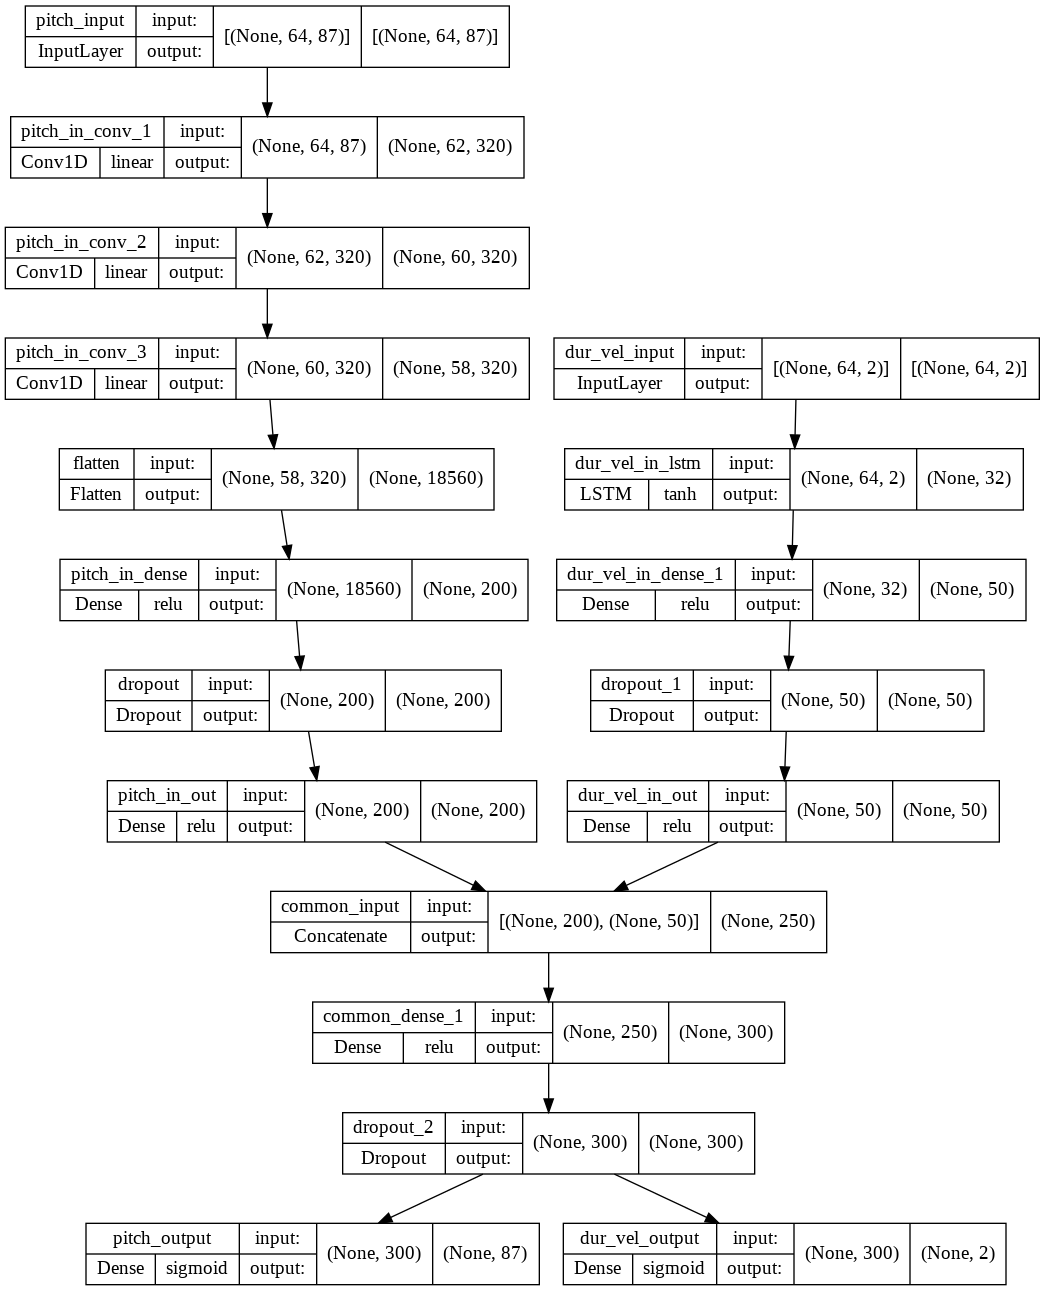

In [18]:
plot_model(model, show_shapes=True, show_layer_names=True, expand_nested=True, show_layer_activations=True)

## Train model

In [ ]:
es = keras.callbacks.EarlyStopping(patience=50, monitor='val_pitch_output_loss', restore_best_weights=True, verbose=10)
model.fit([X_pitches, X_dur_vel], [Y_pitches, Y_dur_vel], epochs=1000, callbacks=[es], batch_size=1024, validation_split=0.1)

## Save model

In [20]:
path = "models/" + str(datetime.now().strftime("%m-%d-%Y_%H-%M-%S"))
model.save(path)

!zip -r {path}.zip {path}

INFO:tensorflow:Assets written to: models/05-14-2022_10-08-38/assets


INFO:tensorflow:Assets written to: models/05-14-2022_10-08-38/assets


  adding: models/05-14-2022_10-08-38/ (stored 0%)
  adding: models/05-14-2022_10-08-38/saved_model.pb (deflated 89%)
  adding: models/05-14-2022_10-08-38/assets/ (stored 0%)
  adding: models/05-14-2022_10-08-38/variables/ (stored 0%)
  adding: models/05-14-2022_10-08-38/variables/variables.index (deflated 71%)
  adding: models/05-14-2022_10-08-38/variables/variables.data-00000-of-00001 (deflated 8%)
  adding: models/05-14-2022_10-08-38/keras_metadata.pb (deflated 93%)


# 6. Evaluation


## Objective evaluation

In [38]:
model.evaluate([X_pitches, X_dur_vel], [Y_pitches, Y_dur_vel])

2777/2777 [==============================] - 176s 63ms/step - loss: 0.1135 - pitch_output_loss: 0.0013 - dur_vel_output_loss: 0.5612 - pitch_output_acc: 0.7497


[0.11354955285787582,
 0.0013189064338803291,
 0.5611541867256165,
 0.7497355341911316]

## Subjective evaluation

In [35]:
generator = MusicGenerator(model, scaler, min_pitch_num=2)
generated = generator.generate(500, temperature=10.0)
generated

/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3162: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).ndim


pitches  duration  velocity
0    [57, 72]  0.264273        66
1    [57, 69]  0.263269        64
2    [57, 72]  0.256564        67
3    [57, 72]  0.255766        67
4    [57, 72]  0.252158        67
..        ...       ...       ...
495  [69, 81]  0.188225        56
496  [78, 80]  0.188240        58
497  [58, 77]  0.188225        58
498  [75, 87]  0.188407        60
499  [77, 85]  0.188253        60

[500 rows x 3 columns]

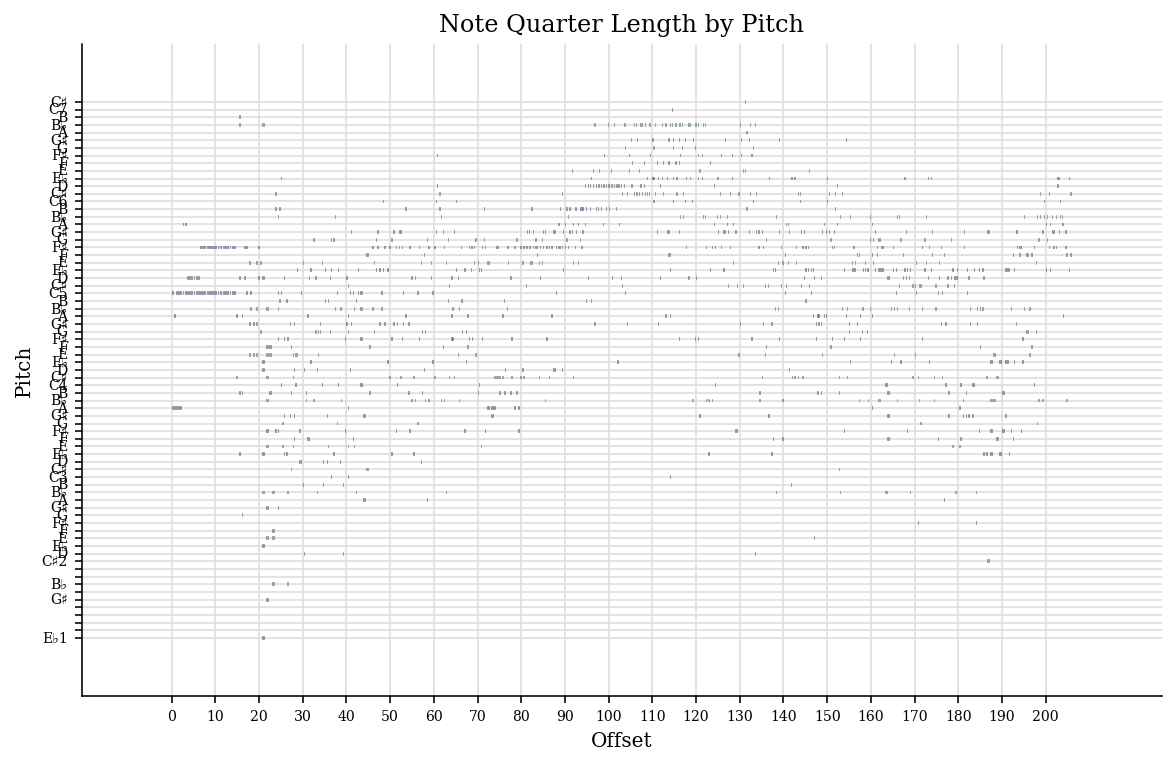

In [36]:
file_name = 'output.mid'
create_midi_file_from_df(generated, file_name)
music = music21.converter.parse(file_name)
music.plot()

In [37]:
Audio(play_music(file_name))